In [36]:


import tensorflow as tf
print(tf.__version__)

2.12.0


In [37]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [38]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

In [40]:
train_df = pd.read_csv('data/lome_train1.csv', index_col='date_time',parse_dates=True)
val_df = pd.read_csv('data/lome_val1.csv', index_col='date_time',parse_dates=True)
test_df = pd.read_csv('data/lome_test1.csv', index_col='date_time',parse_dates=True)

print(train_df.shape, val_df.shape, test_df.shape)


(3735, 21) (1068, 21) (534, 21)


In [41]:
#DataWindow Class

In [42]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='rain_sum (mm)', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [43]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

Multi-output baseline model


In [44]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['precipitation_sum (mm)','rain_sum (mm)','river_discharge','intensity_rain','intensity_flood','intensity_drought'])
mo_wide_window = DataWindow(input_width=14, label_width=14, shift=1, label_columns=['precipitation_sum (mm)','rain_sum (mm)','river_discharge','intensity_rain','intensity_flood','intensity_drought'])

In [45]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [46]:
print(column_indices['precipitation_sum (mm)'])
print(column_indices['rain_sum (mm)'])
print(column_indices['river_discharge'])
print(column_indices['intensity_rain'])
print(column_indices['intensity_flood'])
print(column_indices['intensity_drought'])

7
8
17
18
19
20


In [47]:
mo_baseline_last = Baseline(label_index=[7,8,17,18,19,20])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

 1/33 [..............................] - ETA: 5s - loss: 19.7483 - mean_absolute_error: 1.1222

2023-09-22 11:01:20.566074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:20.566692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1054]
	 [[{{node Placeholder/_8}}]]


33/33 [==============================] - 0s 2ms/step - loss: 27.9405 - mean_absolute_error: 1.1762


2023-09-22 11:01:20.848921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:20.849515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


2023-09-22 11:01:22.793077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-09-22 11:01:22.793700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [3735,21]
	 [[{{node Placeholder/_0}}]]


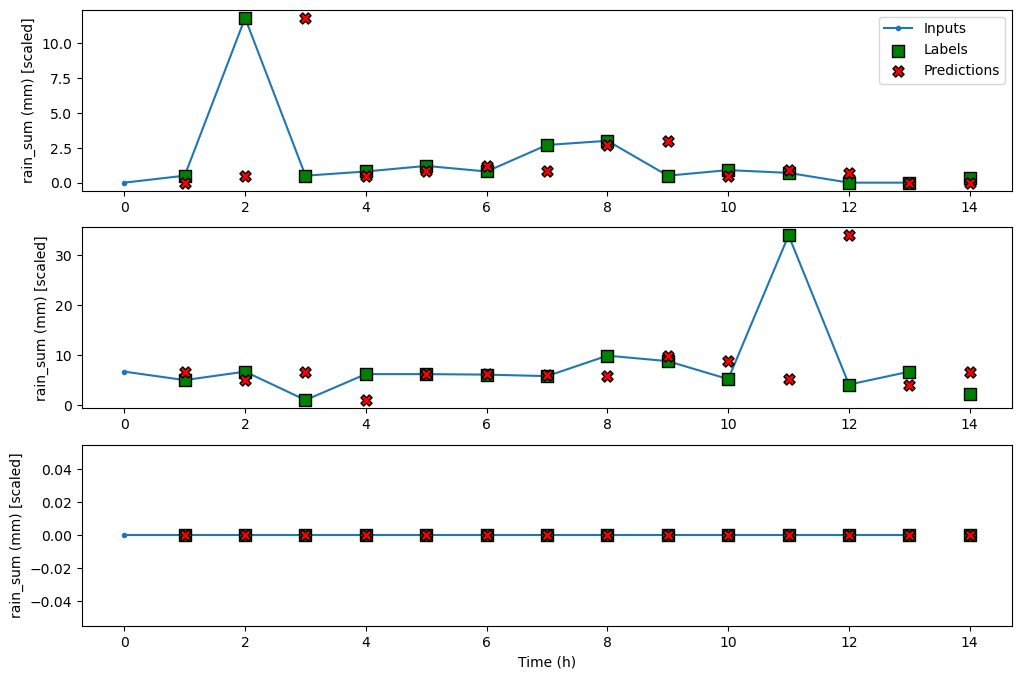

In [48]:
mo_wide_window.plot(mo_baseline_last)

plt.savefig('fig/mo_baseline_last_rain_sum.png', dpi=300)



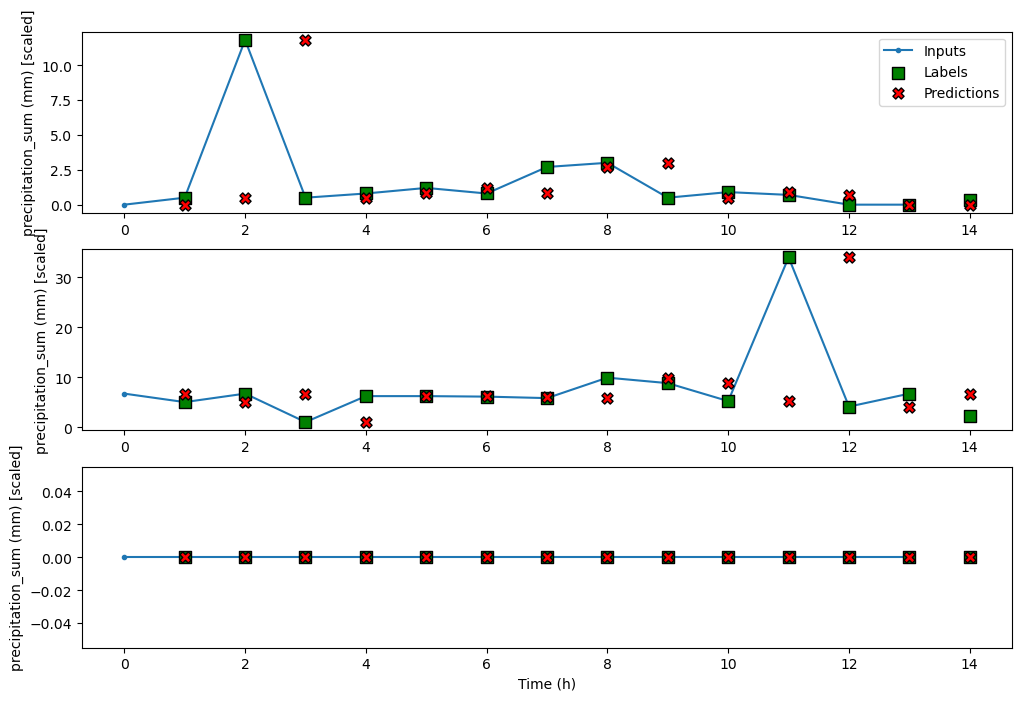

In [49]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='precipitation_sum (mm)')

plt.savefig('fig/mo_baseline_last_precipitation_sum.png', dpi=300)


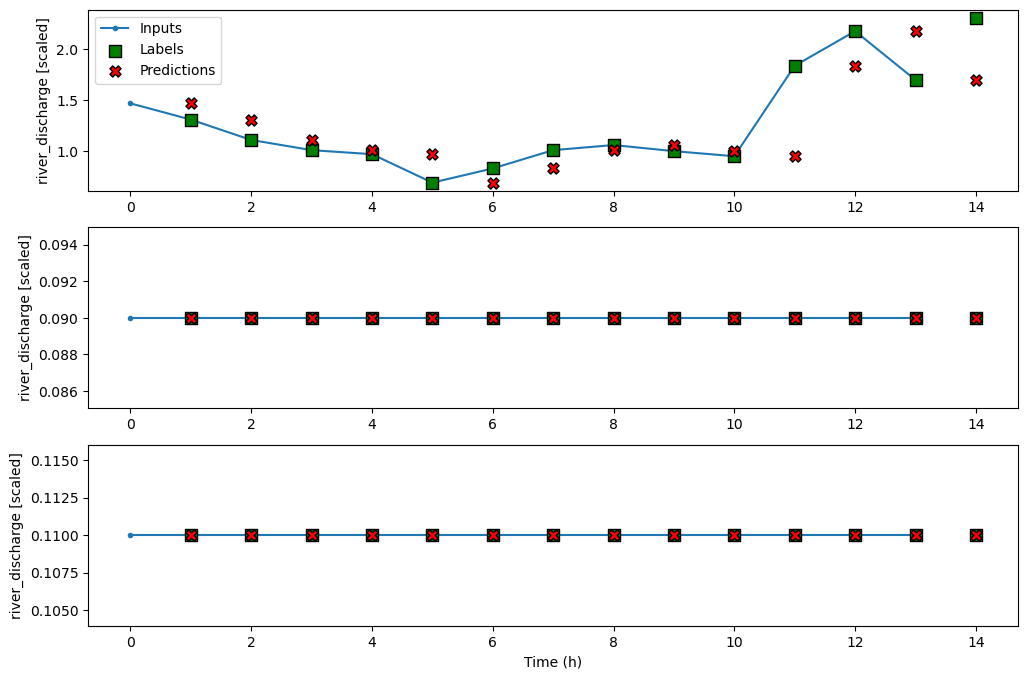

In [50]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='river_discharge')

plt.savefig('fig/mo_baseline_last_river_discharge.png', dpi=300)

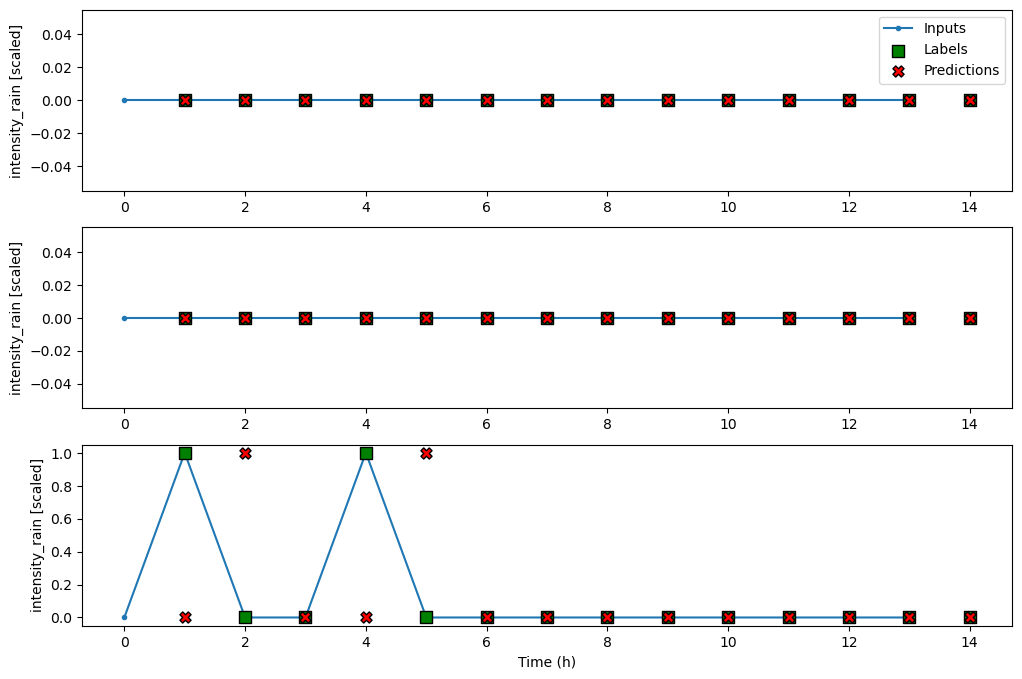

In [51]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='intensity_rain')

plt.savefig('fig/mo_baseline_last_intensity_rain.png', dpi=300)

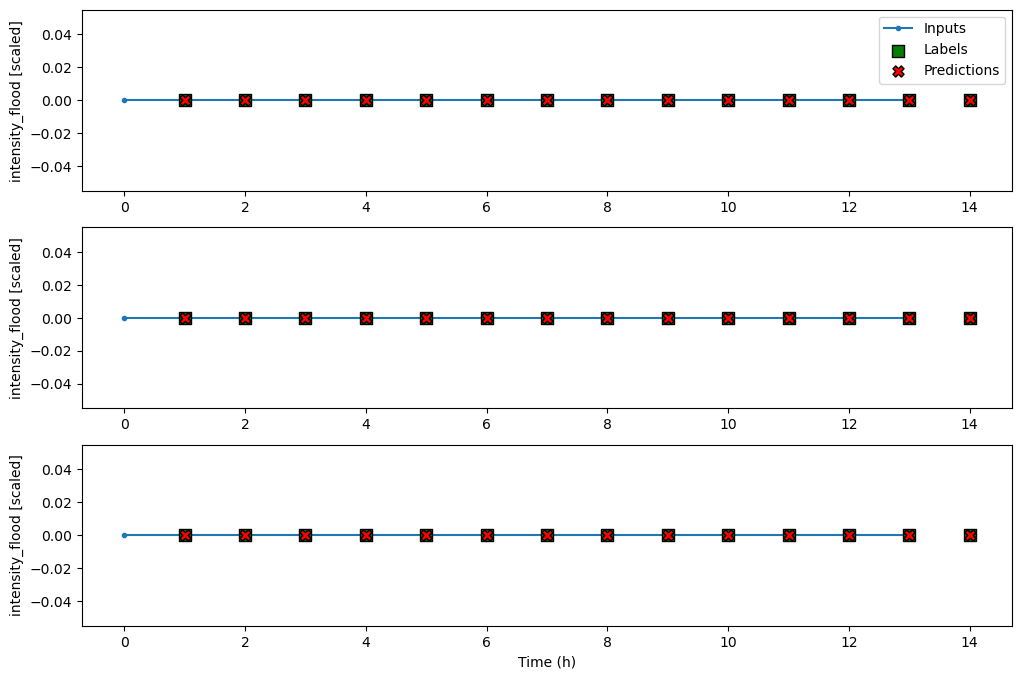

In [52]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='intensity_flood')

plt.savefig('fig/mo_baseline_last_intensity_flood.png', dpi=300)

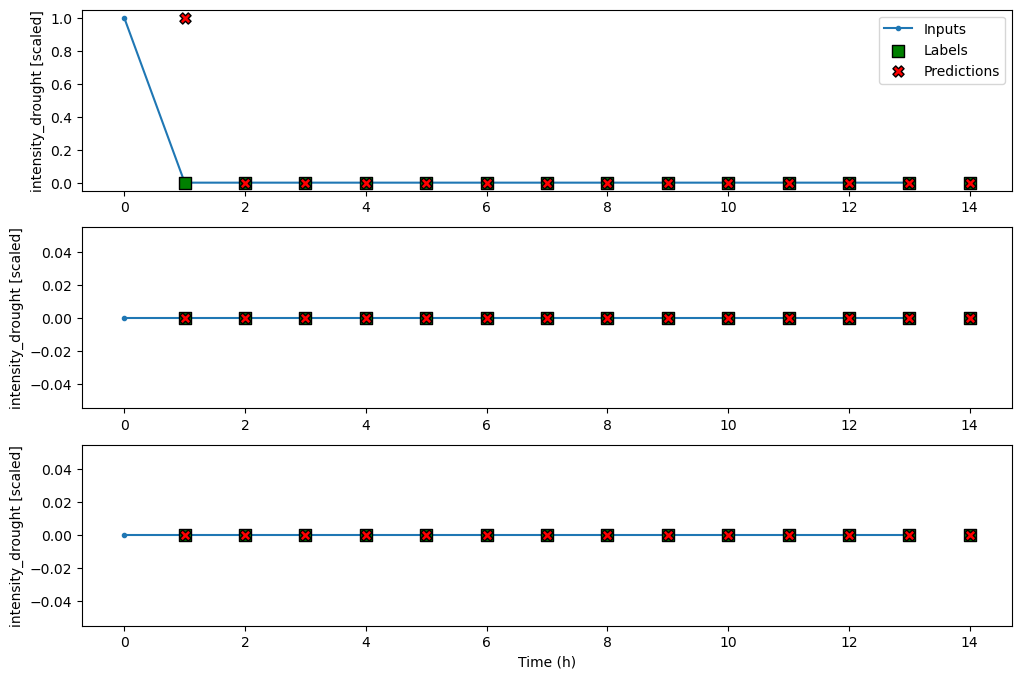

In [53]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='intensity_drought')

plt.savefig('fig/mo_baseline_last_intensity_drought.png', dpi=300)

In [54]:
print(mo_performance['Baseline - Last'][1])

1.2077831029891968


Implementing a deep neural network as a multi-output model

In [55]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [56]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=6)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50


2023-09-22 11:01:37.179145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:37.179680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [3735,21]
	 [[{{node Placeholder/_0}}]]


 87/117 [=====================>........] - ETA: 0s - loss: 63.8122 - mean_absolute_error: 3.9074 

2023-09-22 11:01:38.154378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1067]
	 [[{{node Placeholder/_8}}]]
2023-09-22 11:01:38.154965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


117/117 [==============================] - 1s 4ms/step - loss: 49.9749 - mean_absolute_error: 3.2683 - val_loss: 17.2575 - val_mean_absolute_error: 1.4766
Epoch 2/50
117/117 [==============================] - 0s 3ms/step - loss: 10.8294 - mean_absolute_error: 1.2550 - val_loss: 16.4555 - val_mean_absolute_error: 1.3412
Epoch 3/50
117/117 [==============================] - 0s 3ms/step - loss: 10.5241 - mean_absolute_error: 1.1774 - val_loss: 16.2617 - val_mean_absolute_error: 1.3094
Epoch 4/50
117/117 [==============================] - 0s 3ms/step - loss: 10.5160 - mean_absolute_error: 1.1520 - val_loss: 16.6486 - val_mean_absolute_error: 1.1362
Epoch 5/50
117/117 [==============================] - 0s 3ms/step - loss: 10.2923 - mean_absolute_error: 1.0763 - val_loss: 16.2204 - val_mean_absolute_error: 1.3470
Epoch 6/50
117/117 [==============================] - 0s 3ms/step - loss: 10.4347 - mean_absolute_error: 1.1456 - val_loss: 16.2136 - val_mean_absolute_error: 1.1105
Epoch 7/50
117/

2023-09-22 11:01:42.895019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:42.895550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:43.073799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01

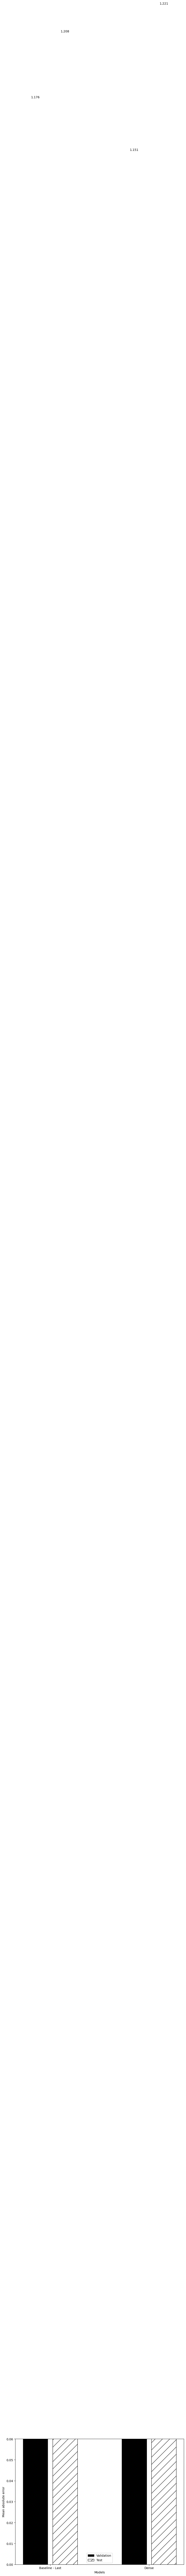

In [57]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('fig/validation_test.png', dpi=300)


**LSTM**

In [58]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 6)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50


2023-09-22 11:01:44.192576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:44.193147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-09-22 11:01:44.439952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

109/117 [==========================>...] - ETA: 0s - loss: 11.9457 - mean_absolute_error: 1.0495

2023-09-22 11:01:47.255767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1068,21]
	 [[{{node Placeholder/_0}}]]
2023-09-22 11:01:47.256304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1054]
	 [[{{node Placeholder/_8}}]]
2023-09-22 11:01:47.471869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'

117/117 [==============================] - 4s 10ms/step - loss: 12.1171 - mean_absolute_error: 1.0442 - val_loss: 18.1768 - val_mean_absolute_error: 1.0755
Epoch 2/50
117/117 [==============================] - 1s 7ms/step - loss: 10.8651 - mean_absolute_error: 0.9292 - val_loss: 17.2155 - val_mean_absolute_error: 1.0653
Epoch 3/50
117/117 [==============================] - 1s 7ms/step - loss: 10.3862 - mean_absolute_error: 0.9220 - val_loss: 16.7593 - val_mean_absolute_error: 1.0537
Epoch 4/50
117/117 [==============================] - 1s 7ms/step - loss: 10.1707 - mean_absolute_error: 0.9142 - val_loss: 16.5300 - val_mean_absolute_error: 1.0579
Epoch 5/50
117/117 [==============================] - 1s 7ms/step - loss: 10.0836 - mean_absolute_error: 0.9148 - val_loss: 16.4764 - val_mean_absolute_error: 1.0486
Epoch 6/50
117/117 [==============================] - 1s 7ms/step - loss: 10.0131 - mean_absolute_error: 0.9077 - val_loss: 16.3507 - val_mean_absolute_error: 1.0005
Epoch 7/50
117

2023-09-22 11:01:57.338231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1068,21]
	 [[{{node Placeholder/_0}}]]
2023-09-22 11:01:57.338826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:01:57.548930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [520]
	 [[{{node Pla

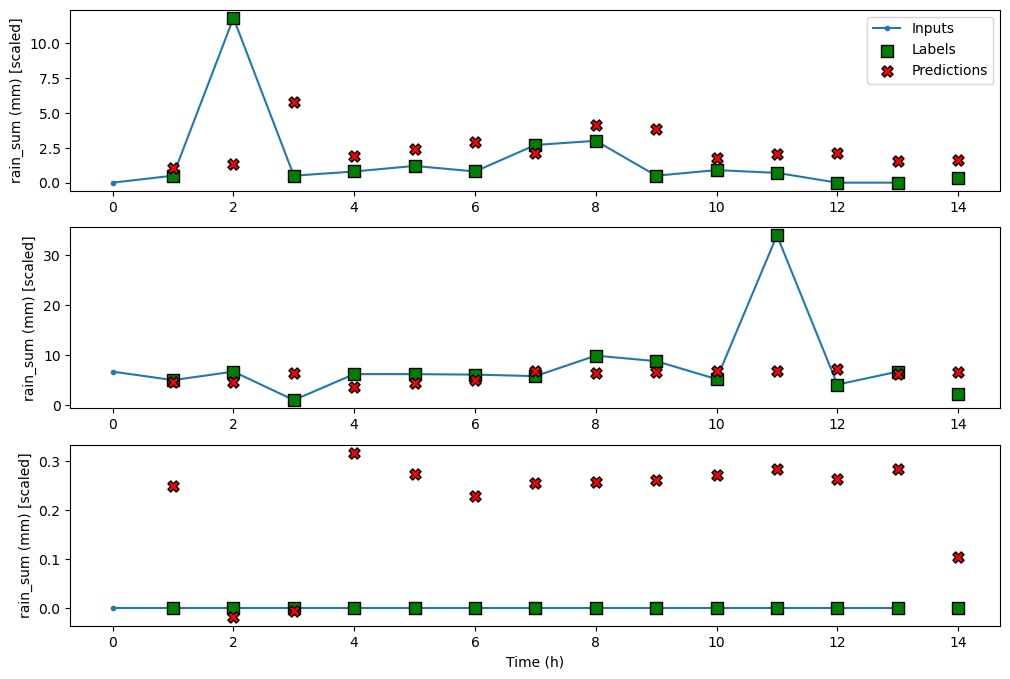

In [59]:
mo_wide_window.plot(mo_lstm_model)

plt.savefig('fig/mo_lstm_model.png', dpi=300)

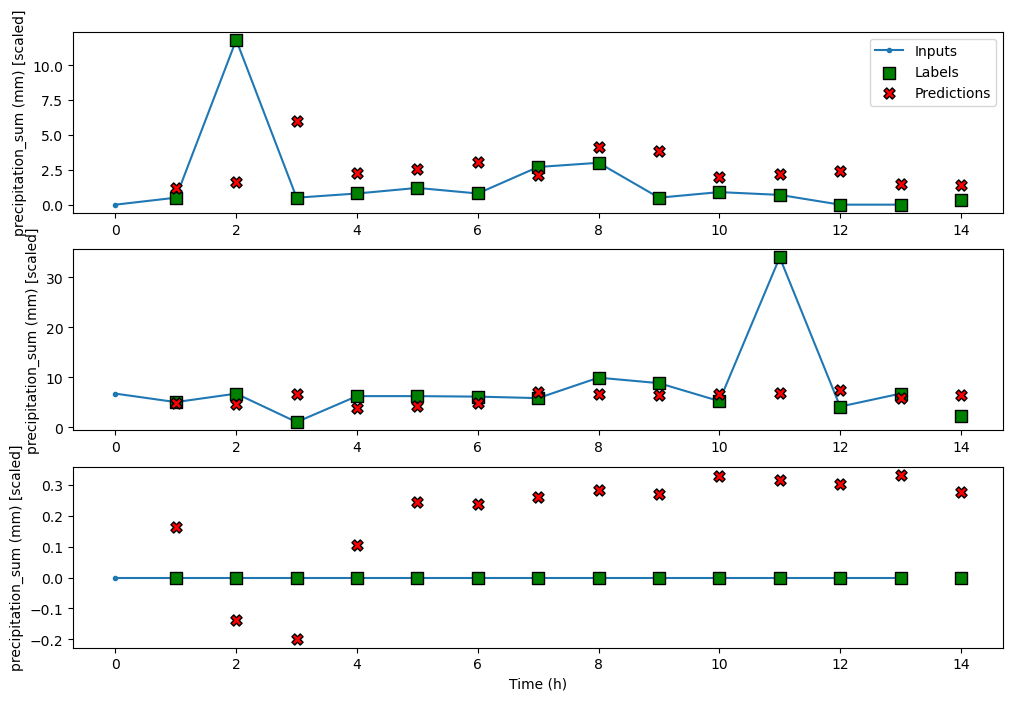

In [60]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='precipitation_sum (mm)')

plt.savefig('fig/mo_lstm_model_precipitation_sum.png', dpi=300)

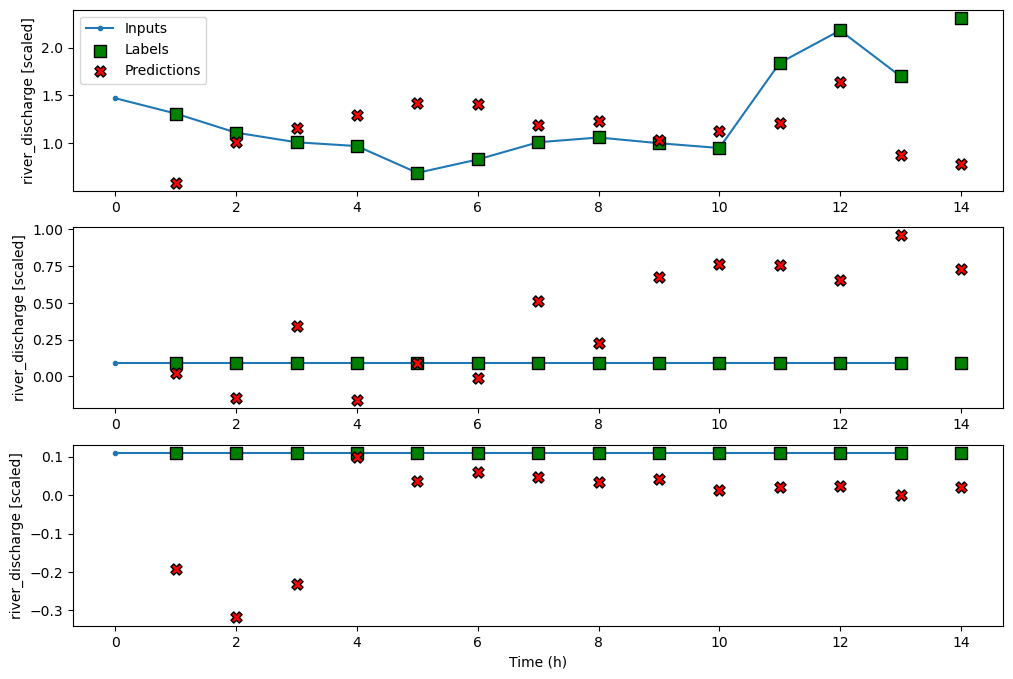

In [61]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='river_discharge')

plt.savefig('fig/mo_lstm_model_river_discharge.png', dpi=300)

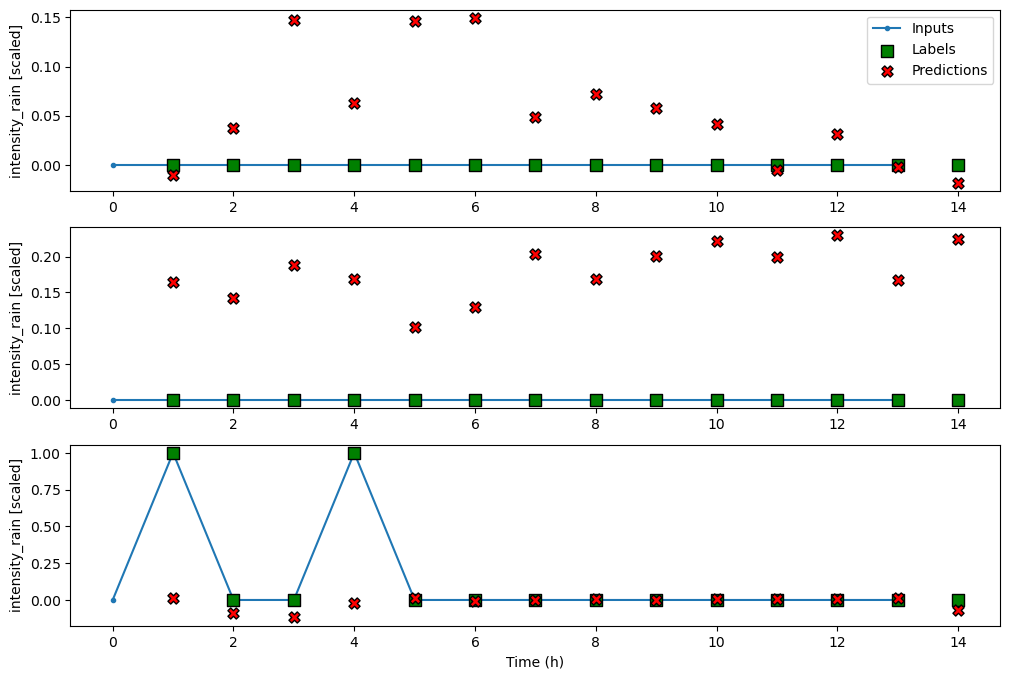

In [62]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='intensity_rain')

plt.savefig('fig/mo_lstm_model_intensity_rain.png', dpi=300)

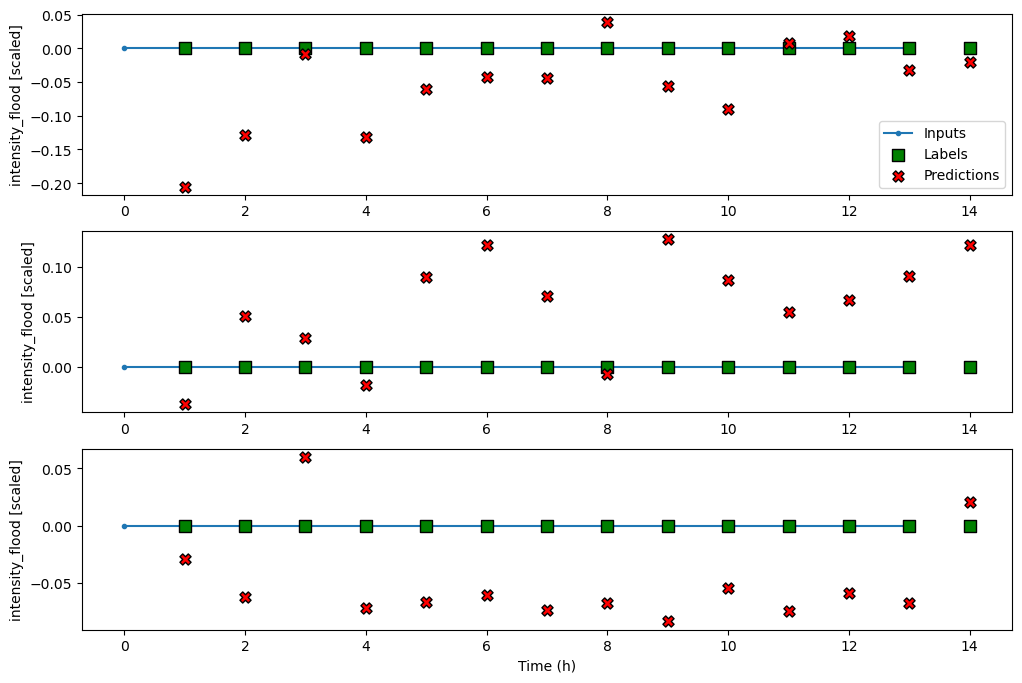

In [63]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='intensity_flood')

plt.savefig('fig/mo_lstm_model_intensity_flood.png', dpi=300)

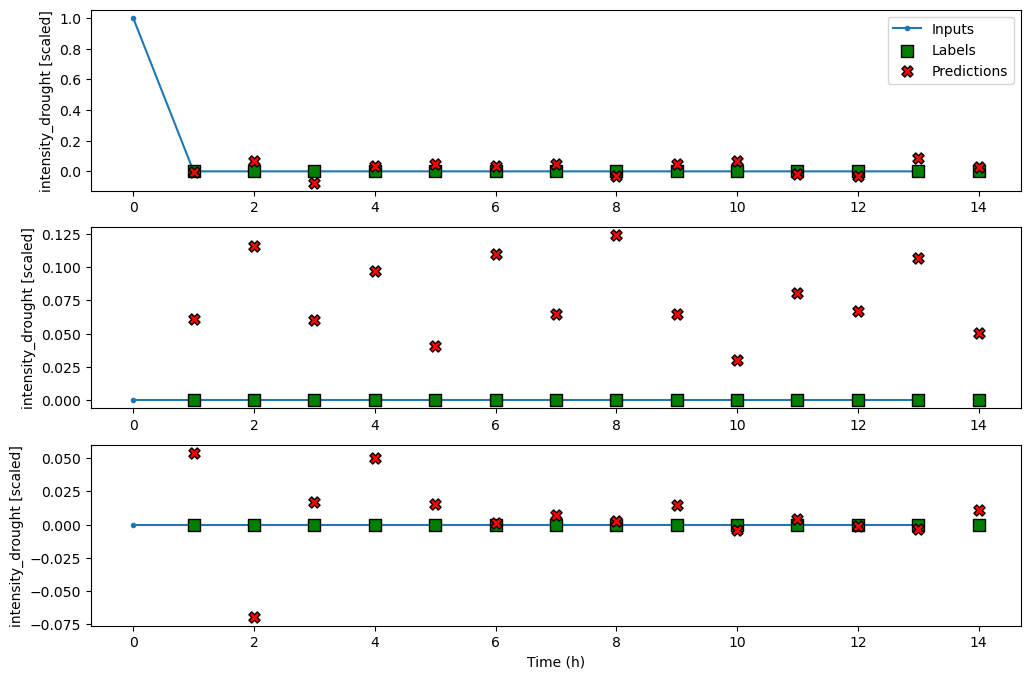

In [64]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='intensity_drought')

plt.savefig('fig/mo_lstm_model_intensity_drought.png', dpi=300)

In [65]:
predicted_results = mo_baseline_last.predict(mo_wide_window.test)
predicted_array= predicted_results[0]

my_array = np.array(predicted_array)

df = pd.DataFrame(my_array)


df2 = df.rename(columns={0: "precipitation_sum (mm)", 1: "rain_sum (mm)",2:"river_discharge",3:"intensity_rain",4:"intensity_flood",5:"intensity_drought"})

df2.head(14)

2023-09-22 11:03:21.488866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-09-22 11:03:21.489799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


17/17 [==============================] - 0s 1ms/step


,precipitation_sum (mm),rain_sum (mm),river_discharge,intensity_rain,intensity_flood,intensity_drought
0,0.2,0.2,0.06,0.0,0.0,0.0
1,0.4,0.4,0.06,0.0,0.0,0.0
2,0.7,0.7,0.06,0.0,0.0,0.0
3,0.5,0.5,0.06,0.0,0.0,0.0
4,0.2,0.2,0.06,0.0,0.0,0.0
5,0.3,0.3,0.06,1.0,0.0,1.0
6,0.4,0.4,0.06,0.0,0.0,1.0
7,0.5,0.5,0.06,0.0,0.0,0.0
8,1.0,1.0,0.06,0.0,0.0,0.0
9,1.5,1.5,0.06,0.0,0.0,0.0


In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df2)

df2[df2.columns] = scaler.inverse_transform(df2[df2.columns])


In [67]:
df2.head(14)

,precipitation_sum (mm),rain_sum (mm),river_discharge,intensity_rain,intensity_flood,intensity_drought
0,0.66,0.66,0.12,0.0,0.0,0.0
1,1.12,1.12,0.12,0.0,0.0,0.0
2,1.81,1.81,0.12,0.0,0.0,0.0
3,1.35,1.35,0.12,0.0,0.0,0.0
4,0.66,0.66,0.12,0.0,0.0,0.0
5,0.89,0.89,0.12,1.0,0.0,1.0
6,1.12,1.12,0.12,0.0,0.0,1.0
7,1.35,1.35,0.12,0.0,0.0,0.0
8,2.50,2.50,0.12,0.0,0.0,0.0
9,3.65,3.65,0.12,0.0,0.0,0.0
